# Performance Counters

Fiddle provide easy access to hardware performance counters to count things like cache misses and branch mispredictions.

<div class="alert alert-block alert-warning">

In order for performance counters to work, you need access to your hardware's performance counters.   You can check the [perf_event_open man page](https://man7.org/linux/man-pages/man2/perf_event_open.2.html) for details about how to enable the `perf_events` interface on your system (It's usually turned on by default).

If you're in docker, you'll also need to start the container with `--privileged`.
    
</div>

Let's use to investigate the performance difference between `std::ordered_set` and `std::set` in the C++ STL.

## The Code

The code provides two functions that each fill a set with random integers.  We'll compile it with full optimizations.

In [76]:
from fiddle import *
from fiddle.perfcount import *

In [77]:
exe = build(code(r"""
#include<set>
#include<unordered_set>
#include"fiddle.hpp"

extern "C"
int build_set(int count) {
    std::set<uint64_t> s;
    uint64_t seed = 0xDEADBEEF;
    start_measurement();
    for(int i= 0; i < count; i++) {
        s.insert(fast_rand(&seed));
    }
    end_measurement();
    return s.size();
}

extern "C"
int build_unordered_set(int count) {
    std::unordered_set<uint64_t> s;
    uint64_t seed = 0xDEADBEEF;
    start_measurement();
    for(int i= 0; i < count; i++) {
        s.insert(fast_rand(&seed));
    }
    end_measurement();
    return s.size();
}

"""), map_product(OPTIMIZE="-O3"))

## Measuring Cache Misses and Instructions Executed

Here's the command to run the program and measure performance counters:

In [78]:
def exp_range(base, low, high):
    return [2**i for i in range(low,high)]

results = run(exe, 
              ["build_set", "build_unordered_set"], 
              map_product(count=exp_range(2,8,24)), 
              perf_counters=[CacheCounter(L1D, READ, MISS),
                             INSTRUCTIONS])

The key is the `perf_counters` parameter which takes a list of performance counters to measure.  Fiddle supports all the hardware, software, and cache counters described in the [perf_event_open() man page](https://man7.org/linux/man-pages/man2/perf_event_open.2.html).  In this case, we'll count the number of level-1 data cach (`L1D`), read misses and the total number instructions executed.

We use Pandas data from opererations to compute some dervived metrics:

In [79]:
r = results.as_df()
r['L1_MissPerInsert'] = r["L1D_READ_MISS"]/r["count"]
r['InstPerInsert'] = r["INSTRUCTIONS"]/r["count"]
r['L1_MPI'] = r["L1D_READ_MISS"]/r["INSTRUCTIONS"]
display(r)

,OPTIMIZE,function,count,ET,L1D_READ_MISS,INSTRUCTIONS,L1_MissPerInsert,InstPerInsert,L1_MPI
0,-O3,build_set,256,0.000118,803,100123,3.136719,391.105469,0.008020
1,-O3,build_set,512,0.000151,1942,205166,3.792969,400.714844,0.009466
2,-O3,build_set,1024,0.000195,5050,422355,4.931641,412.456055,0.011957
3,-O3,build_set,2048,0.000455,14181,865485,6.924316,422.600098,0.016385
4,-O3,build_set,4096,0.000629,24414,1769798,5.960449,432.079590,0.013795
5,-O3,build_set,8192,0.001346,62694,3607691,7.653076,440.391968,0.017378
6,-O3,build_set,16384,0.002986,154385,7355898,9.422913,448.968384,0.020988
7,-O3,build_set,32768,0.006688,367823,14989567,11.225067,457.445282,0.024539
8,-O3,build_set,65536,0.014700,838059,30505111,12.787766,465.471054,0.027473
9,-O3,build_set,131072,0.033757,1880076,62112541,14.343842,473.881081,0.030269


And then we can reshuffle that data to make comparisons and plotting easier:

In [80]:
import pandas as pd
pt = pd.pivot_table(r, index="count", values=["InstPerInsert", "L1_MissPerInsert", "ET"], columns="function")
display(pt)

ET                     InstPerInsert                      \
function build_set build_unordered_set     build_set build_unordered_set   
count                                                                      
256       0.000118            0.000040    391.105469          350.054688   
512       0.000151            0.000060    400.714844          348.316406   
1024      0.000195            0.000108    412.456055          345.782227   
2048      0.000455            0.000207    422.600098          342.803711   
4096      0.000629            0.000411    432.079590          341.740479   
8192      0.001346            0.000824    440.391968          341.995239   
16384     0.002986            0.001691    448.968384          342.237427   
32768     0.006688            0.003540    457.445282          342.308533   
65536     0.014700            0.006827    465.471054          342.526566   
131072    0.033757            0.013280    473.881081          342.668831   
262144    0.080452            0.034281    482.064148          342.951973   
524288    0.198785            0.088309    490.345572          343.260534   
1048576   0.495226            0.237698    498.675838          343.577345   
2097152   1.191870            0.577196    506.897974          343.930752   
4194304   3.017340            1.426890    514.899406          344.295421   
8388608   7.748630            3.399160    522.656025          344.676640   

         L1_MissPerInsert                      
function        build_set build_unordered_set  
count                                          
256              3.136719            1.335938  
512              3.792969            1.207031  
1024             4.931641            1.314453  
2048             6.924316            2.293945  
4096             5.960449            3.427734  
8192             7.653076            4.430420  
16384            9.422913            5.124084  
32768           11.225067            5.550903  
65536           12.787766            5.830811  
131072          14.343842            6.004906  
262144          16.690308            6.467430  
524288          20.058954            7.344337  
1048576         23.125141            8.363354  
2097152         26.248382            9.298848  
4194304         29.656966           10.047923  
8388608         32.552544           10.600879

## The Results

The results provide some insight into why `std::ordered_set` is roughly twice as fast at as `std::set` for inserts: While the number of instructions per access grows pretty slowly, the number _cache misses_ per accesses grows much faster for `std::set`  than `std::ordered_set`.

<AxesSubplot:xlabel='count', ylabel='ET'>

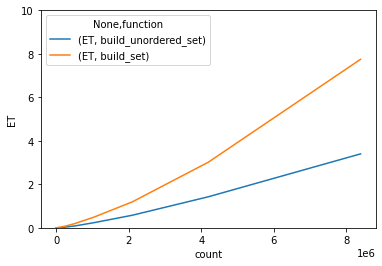

In [81]:
pt.plot.line(y=[("ET", "build_unordered_set"), ("ET", "build_set")], ylim=(0,10), ylabel="ET")

<AxesSubplot:xlabel='count', ylabel='Instruction Per Insert'>

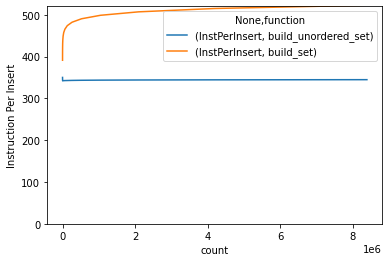

In [82]:
pt.plot.line(y=[("InstPerInsert", "build_unordered_set"), ("InstPerInsert", "build_set")], ylim=(0,520), ylabel="Instruction Per Insert")

<AxesSubplot:xlabel='count', ylabel='Misses per Insert'>

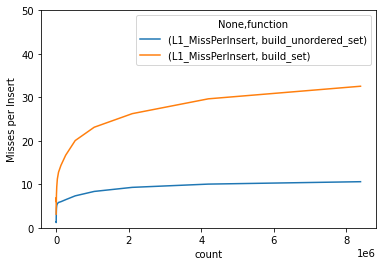

In [83]:
pt.plot.line(y=[("L1_MissPerInsert", "build_unordered_set"), ("L1_MissPerInsert", "build_set")], ylim=(0,50), ylabel="Misses per Insert")